In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [2]:
DATASET_SIZE = 70000
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

x_train_orig, x_valid_orig, y_train_orig, y_valid_orig = train_test_split(x, y, test_size=(1-TRAIN_RATIO))
x_valid_orig, x_test_orig, y_valid_orig, y_test_orig = train_test_split(x_valid_orig, y_valid_orig, test_size=((TEST_RATIO/(VALIDATION_RATIO+TEST_RATIO))))

In [3]:
# change the format of data 
def data_format(y): 
    y_10 = []
    for i in np.arange(10): 
        temp = (y==i).astype(int)
        y_10 = np.append(y_10, temp)
        #print(y_10)
    y_10 = y_10.reshape(y.shape[0], -1, order='F')
    return y_10 

# normalize data 
x_train = x_train_orig.reshape(x_train_orig.shape[0], -1).astype('float32')/255.
y_train = data_format(y_train_orig)

x_valid = x_valid_orig.reshape(x_valid_orig.shape[0], -1).astype('float32')/255.
y_valid = data_format(y_valid_orig)

x_test = x_test_orig.reshape(x_test_orig.shape[0], -1).astype('float32')/255.
y_test = data_format(y_test_orig)

In [4]:
# minimization function 
def min_fun(x, y, w, lambda_): 
    N = np.shape(x)[0]
    K = np.shape(w)[0]
    I = np.identity(K)
    one = np.ones(N)
    x_ = np.c_[x, one]
    S = np.cos(x_.dot(w.T)) 
    beta = np.linalg.inv(np.dot(S.T, S) + lambda_ * N * I).dot(S.T).dot(y)
    return beta, S

In [5]:
def error_compute(y, pred):
    #error = - np.sum(np.diagonal(y.dot(np.log(pred+1e-10).T)))
    # y pred in N*10
    #error = np.mean(np.sum((y-pred)**2, axis=1))
    N = np.shape(y)[0]
    y_index = np.argmax(y, 1)
    pred_index = np.argmax(pred, 1)
    error = np.linalg.norm((y_index-pred_index), ord=2)/N
    return error

In [6]:
def accuracy_compute(y, pred): 
    y_index = np.argmax(y, 1)
    pred_index = np.argmax(pred, 1)
    accuracy = np.mean((pred_index==y_index).astype('int'))
    return accuracy

In [7]:
# Metropolis algorithm 1
#def algorithm_1(x_train, y_train, x_test, y_test, x_validation, y_validation, K, M, lambda_, delta, gamma):
def algorithm_1(x_train, y_train, x_valid, y_valid, x_test, y_test, K, M, lambda_, delta, gamma):
    
    # normalize the data 
    #x_mean = np.mean(x_train)
    #x_std = np.std(x_train, ddof=1)
    #y_mean = np.mean(y_train)
    #y_std = np.std(y_train, ddof=1)
    
    #x_train_norm = (x_train - x_mean)/x_std
    #y_train_norm = (y_train - y_mean)/y_std
    #x_test_norm = (x_test - x_mean)/x_std
    #y_test_norm = (y_test - y_mean)/y_std
    #x_validation_norm = (x_validation - x_mean)/x_std
    #y_validation_norm = (y_validation - y_mean)/y_std
    
    N = np.shape(x_train)[0]
    d = np.shape(x_train)[1] 
    w = np.zeros(K*(d+1)).reshape((K, d+1)) #? 
    
    error_train_list = []
    error_valid_list = []
    error_test_list = []
    
    accuracy_train_list = []
    accuracy_valid_list = []
    accuracy_test_list = []
  
    #beta, S = min_fun(x_train_norm, y_train_norm, w, lambda_)
    beta = np.zeros(10*K).reshape(10, K)
    S = np.zeros(10*N*K).reshape(10, N, K)
    for i in np.arange(10): 
        beta[i],  S[i] = min_fun(x_train, y_train[:,i], w, lambda_)
    #print(beta)
    
    
    for epoch in range(M): 
        #print('w=', i)
        r_n = np.random.normal(0, 1, K*(d+1)).reshape((K, d+1))
        w_temp = w + delta * r_n
        #print(w_temp)
        #beta_temp, S_temp = min_fun(x_train_norm, y_train_norm, w_temp, lambda_)
        beta_temp = np.zeros(10*K).reshape(10, K)
        S_temp = np.zeros(10*N*K).reshape(10, N, K)
        for i in np.arange(10): 
            beta_temp[i],  S_temp[i] = min_fun(x_train, y_train[:,i], w_temp, lambda_)
        #print(beta_temp)
        
        for k in range(K): 
            #print('k=', k)
            r_u = np.random.uniform(0, 1)
            #print(np.linalg.norm(beta_temp[:,k], ord=2))
            #print(np.linalg.norm(beta[:,k], ord=2))
            #print(r_u)
            #print((np.linalg.norm(beta_temp[:,k], ord=2)/np.linalg.norm(beta[:,k], ord=2))**gamma)
            
            if (np.linalg.norm(beta_temp[:,k], ord=2)
                /np.linalg.norm(beta[:,k], ord=2))**gamma > r_u: 
                #print('yes')
                w[k] = w_temp[k]
                #print('w_k', w[k])
                beta[:,k] = beta_temp[:,k]
                #print('beta_k', beta[k])
                
        #beta, S = min_fun(x_train_norm, y_train_norm, w, lambda_)
        beta = np.zeros(10*K).reshape(10, K)
        S = np.zeros(10*N*K).reshape(10, N, K)
        for i in np.arange(10): 
            beta[i],  S[i] = min_fun(x_train, y_train[:,i], w, lambda_)
        
        #f_est_train = S.dot(beta) * y_std + y_mean
        pred_train = np.zeros(10*N).reshape(N, 10)
        for i in np.arange(10): 
            pred_train[:,i] = S[i].dot(beta[i])
        error_train = error_compute(y_train, pred_train)
        error_train_list = np.append(error_train_list, error_train)
        accuracy_train = accuracy_compute(y_train, pred_train)
        accuracy_train_list = np.append(accuracy_train_list, accuracy_train)
        
        #beta_validation, S_validation = min_fun(x_valid, y_valid, w, lambda_)
        #f_est_validation = S_validation.dot(beta) * y_std + y_mean
        N_valid = np.shape(x_valid)[0]
        beta_valid = np.zeros(10*K).reshape(10, K)
        S_valid = np.zeros(10*N_valid*K).reshape(10, N_valid, K)
        for i in np.arange(10): 
            beta_valid[i],  S_valid[i] = min_fun(x_valid, y_valid[:,i], w, lambda_)
        pred_valid = np.zeros(10*N_valid).reshape(N_valid, 10)
        for i in np.arange(10): 
            pred_valid[:,i] = S_valid[i].dot(beta[i])
        error_valid= error_compute(y_valid, pred_valid)
        error_valid_list = np.append(error_valid_list, error_valid)
        accuracy_valid= accuracy_compute(y_valid, pred_valid)
        accuracy_valid_list = np.append(accuracy_valid_list, accuracy_valid)
        
        #beta_test, S_test = min_fun(x_test_norm, y_test_norm, w, lambda_)
        #f_est_test = S_test.dot(beta) * y_std + y_mean
        N_test = np.shape(x_test)[0]
        beta_test = np.zeros(10*K).reshape(10, K)
        S_test = np.zeros(10*N_test*K).reshape(10, N_test, K)
        for i in np.arange(10): 
            beta_test[i],  S_test[i] = min_fun(x_test, y_test[:,i], w, lambda_)
        pred_test = np.zeros(10*N_test).reshape(N_test, 10)
        for i in np.arange(10): 
            pred_test[:,i] = S_test[i].dot(beta[i])
        error_test = error_compute(y_test, pred_test)
        error_test_list = np.append(error_test_list, error_test)
        accuracy_test = accuracy_compute(y_test, pred_test)
        accuracy_test_list = np.append(accuracy_test_list, accuracy_test)
    
        # Print the training loss for every epoch
        print("\nEnd of epoch  " + str(epoch) + ", Training error " + str(error_train) + ",Accuracy " + str(accuracy_train)) 
        print("\nEnd of epoch  " + str(epoch) + ", Validation error " + str(error_valid) + ", Validation accuracy " + str(accuracy_valid))
        
    #error_valid_min = np.min(error_validation_list)
    
    #error_test_end = error_compute(y_test_norm, S_test, beta_test)
        
    #return beta, w, f_est_train, f_est_validation, error_train_list, error_validation_list, error_test_list,error_valid_min, error_test_end
    return beta, w, pred_train, pred_valid, pred_test, error_train_list, error_valid_list, error_test_list, accuracy_train_list, accuracy_valid_list, accuracy_test_list

In [8]:
def result_plot(x_train, y_train, x_valid, y_valid, x_test, y_test,
              M = 100, K = 2**5, lambda_ = 0.1, delta = 0.1, gamma = 1): 
    beta, w, pred_train, pred_valid, pred_test, error_train_list, error_valid_list, error_test_list, accuracy_train_list, accuracy_valid_list, accuracy_test_list = algorithm_1(
    x_train, y_train, x_valid, y_valid, x_test, y_test, K, M, lambda_, delta, gamma)
    
    plt.figure(figsize=(10, 6))
    epoch_list = np.arange(1, 101)
    plt.subplot(1, 2,  1)
    plt.semilogy(epoch_list, error_train_list, label = 'training_loss')
    plt.semilogy(epoch_list, error_valid_list, label = 'validation_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, accuracy_train_list*100, label = 'accuracy_loss')
    plt.plot(epoch_list, accuracy_valid_list*100, label = 'accuracy_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('%')
    plt.title('Accuracy')
    plt.tight_layout()
    plt.show()
    
    accuracy_valid_max = np.max(accuracy_valid_list)
    return accuracy_valid_max


 for k=1

End of epoch  0, Training error 0.020071078182085585,Accuracy 0.1407987918120778

End of epoch  0, Validation error 0.037286945792470216, Validation accuracy 0.141

End of epoch  1, Training error 0.020071078182085585,Accuracy 0.1407987918120778

End of epoch  1, Validation error 0.037286945792470216, Validation accuracy 0.141

End of epoch  2, Training error 0.020071078182085585,Accuracy 0.1407987918120778

End of epoch  2, Validation error 0.037286945792470216, Validation accuracy 0.141

End of epoch  3, Training error 0.020071078182085585,Accuracy 0.1407987918120778

End of epoch  3, Validation error 0.037286945792470216, Validation accuracy 0.141

End of epoch  4, Training error 0.01423746758046549,Accuracy 0.11700238780383274

End of epoch  4, Validation error 0.026547608370700394, Validation accuracy 0.11807142857142858

End of epoch  5, Training error 0.01423746758046549,Accuracy 0.11700238780383274

End of epoch  5, Validation error 0.026547608370700394, Validation a

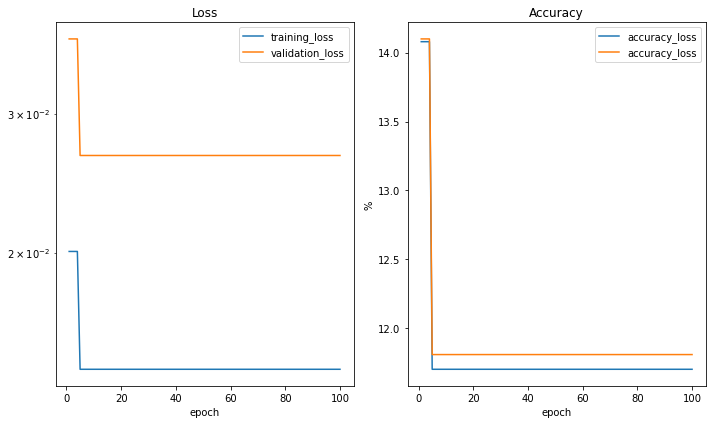


 for k=2


<ipython-input-7-55bef441b035>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.019772491006506417,Accuracy 0.15373783138431396

End of epoch  0, Validation error 0.036732138516563394, Validation accuracy 0.15407142857142858

End of epoch  1, Training error 0.019772491006506417,Accuracy 0.15373783138431396

End of epoch  1, Validation error 0.036732138516563394, Validation accuracy 0.15407142857142858

End of epoch  2, Training error 0.020827013148075658,Accuracy 0.16422784138451804

End of epoch  2, Validation error 0.038744189821158466, Validation accuracy 0.1722857142857143

End of epoch  3, Training error 0.020827013148075658,Accuracy 0.16422784138451804

End of epoch  3, Validation error 0.038744189821158466, Validation accuracy 0.1722857142857143

End of epoch  4, Training error 0.020827013148075658,Accuracy 0.16422784138451804

End of epoch  4, Validation error 0.038744189821158466, Validation accuracy 0.1722857142857143

End of epoch  5, Training error 0.020594633466261274,Accuracy 0.15110512459437947

End of epoch  5, Va

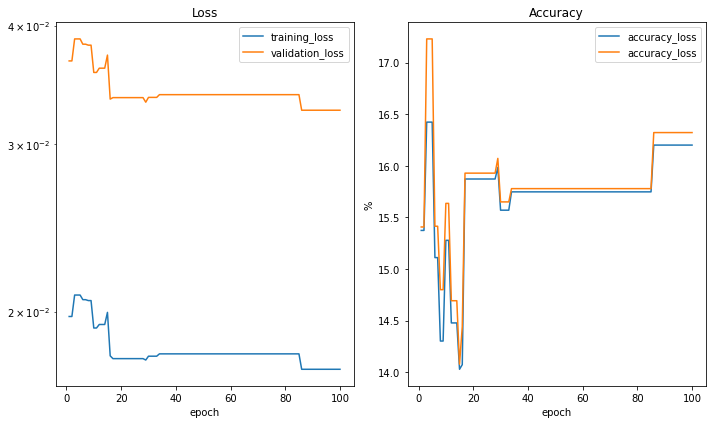


 for k=4


<ipython-input-7-55bef441b035>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.017058179055083143,Accuracy 0.23335170105512357

End of epoch  0, Validation error 0.03177319175477519, Validation accuracy 0.22914285714285715

End of epoch  1, Training error 0.016914859422346662,Accuracy 0.27533214963570685

End of epoch  1, Validation error 0.03135095936428779, Validation accuracy 0.27635714285714286

End of epoch  2, Training error 0.016914859422346662,Accuracy 0.27533214963570685

End of epoch  2, Validation error 0.03135095936428779, Validation accuracy 0.27635714285714286

End of epoch  3, Training error 0.017606726727694325,Accuracy 0.2574338251801057

End of epoch  3, Validation error 0.032713739858203375, Validation accuracy 0.25771428571428573

End of epoch  4, Training error 0.017999904568900195,Accuracy 0.2741688605889916

End of epoch  4, Validation error 0.03340559344584957, Validation accuracy 0.27635714285714286

End of epoch  5, Training error 0.017999904568900195,Accuracy 0.2741688605889916

End of epoch  5, Valida

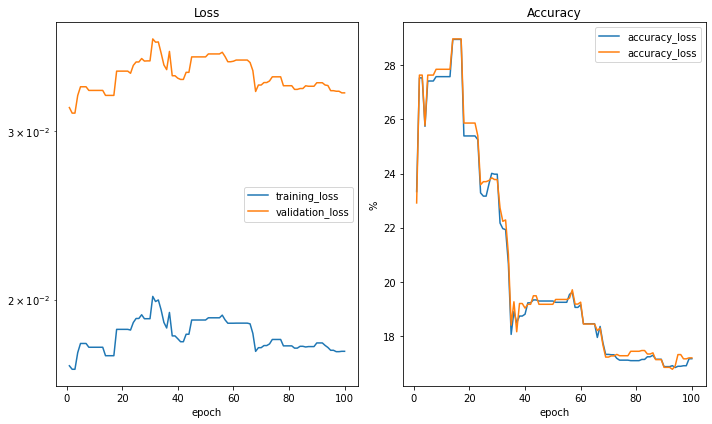


 for k=8


<ipython-input-7-55bef441b035>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.015309033297128164,Accuracy 0.35235412967611585

End of epoch  0, Validation error 0.028583747344337093, Validation accuracy 0.35335714285714287

End of epoch  1, Training error 0.015011006404081558,Accuracy 0.3623339251821466

End of epoch  1, Validation error 0.028337524699988337, Validation accuracy 0.3613571428571429

End of epoch  2, Training error 0.014830467111873491,Accuracy 0.3627625053572522

End of epoch  2, Validation error 0.027764406078610058, Validation accuracy 0.3638571428571429

End of epoch  3, Training error 0.01418190724864488,Accuracy 0.36537480356741975

End of epoch  3, Validation error 0.026634334140391812, Validation accuracy 0.36728571428571427

End of epoch  4, Training error 0.014312090427678769,Accuracy 0.3799669381007776

End of epoch  4, Validation error 0.026736526265292836, Validation accuracy 0.37914285714285717

End of epoch  5, Training error 0.014395804800330212,Accuracy 0.36680340415110513

End of epoch  5, Valid

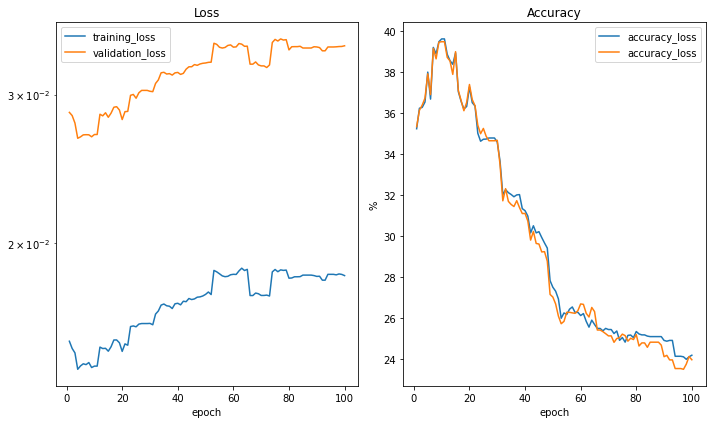


 for k=16


<ipython-input-7-55bef441b035>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.013416262571604252,Accuracy 0.47727504642951896

End of epoch  0, Validation error 0.02489447115079071, Validation accuracy 0.48014285714285715

End of epoch  1, Training error 0.013094978780834907,Accuracy 0.497050960223678

End of epoch  1, Validation error 0.024647101083834073, Validation accuracy 0.49614285714285716

End of epoch  2, Training error 0.013088281724756118,Accuracy 0.5080920018775893

End of epoch  2, Validation error 0.024494272550028954, Validation accuracy 0.5091428571428571

End of epoch  3, Training error 0.012910681129453695,Accuracy 0.5115206432784343

End of epoch  3, Validation error 0.024223238968446168, Validation accuracy 0.5137142857142857

End of epoch  4, Training error 0.012881484266761377,Accuracy 0.5174799485703789

End of epoch  4, Validation error 0.024043222134569338, Validation accuracy 0.5138571428571429

End of epoch  5, Training error 0.013357848099870022,Accuracy 0.5011939019163656

End of epoch  5, Validatio

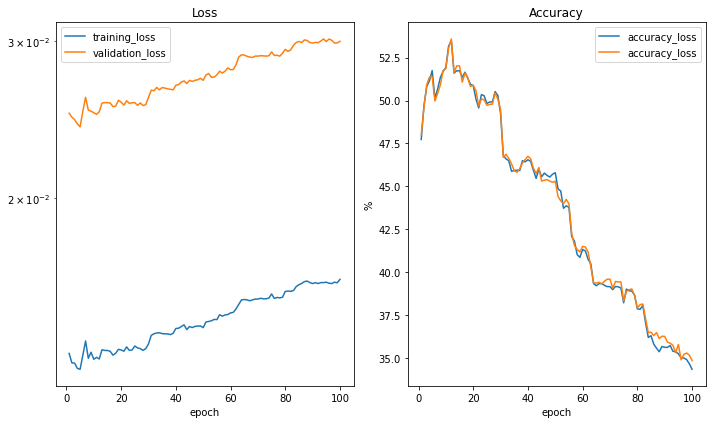


 for k=32


<ipython-input-7-55bef441b035>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.011789501487296688,Accuracy 0.5845629502642911

End of epoch  0, Validation error 0.02196994700559315, Validation accuracy 0.5857857142857142

End of epoch  1, Training error 0.011639083001898762,Accuracy 0.6226861772689238

End of epoch  1, Validation error 0.02182245146071133, Validation accuracy 0.6272857142857143

End of epoch  2, Training error 0.0117576979085466,Accuracy 0.6313394150901038

End of epoch  2, Validation error 0.021909950213712195, Validation accuracy 0.6361428571428571

End of epoch  3, Training error 0.011498437263133524,Accuracy 0.6488907936896672

End of epoch  3, Validation error 0.02128655319535729, Validation accuracy 0.6542857142857142

End of epoch  4, Training error 0.011452177748257414,Accuracy 0.6606053184758872

End of epoch  4, Validation error 0.021179384470059848, Validation accuracy 0.6662857142857143

End of epoch  5, Training error 0.011629327371145436,Accuracy 0.6555643992734546

End of epoch  5, Validation erro

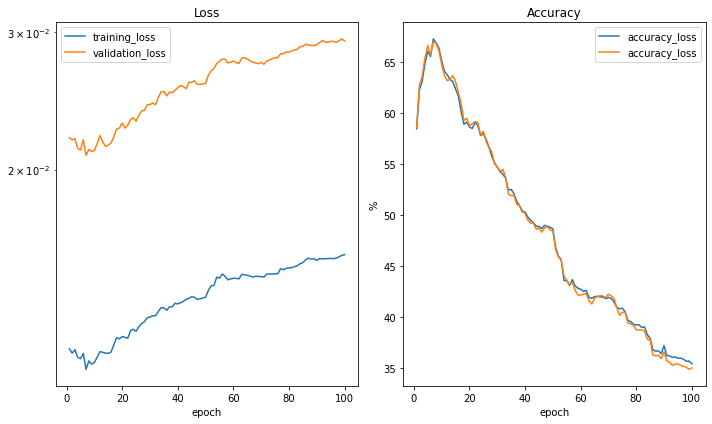


 for k=64


<ipython-input-7-55bef441b035>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.010321294949010556,Accuracy 0.7065450315312557

End of epoch  0, Validation error 0.01928558201012839, Validation accuracy 0.7102142857142857

End of epoch  1, Training error 0.009748787848778168,Accuracy 0.7321986162982917

End of epoch  1, Validation error 0.01840599392167937, Validation accuracy 0.7312857142857143

End of epoch  2, Training error 0.009483513692790633,Accuracy 0.7467295250923488

End of epoch  2, Validation error 0.017806642878775463, Validation accuracy 0.7471428571428571

End of epoch  3, Training error 0.00915210466405578,Accuracy 0.7560562460458377

End of epoch  3, Validation error 0.01729707418930161, Validation accuracy 0.7514285714285714

End of epoch  4, Training error 0.00870200398587626,Accuracy 0.7779750607155248

End of epoch  4, Validation error 0.01640775078169722, Validation accuracy 0.7725714285714286

End of epoch  5, Training error 0.008887063633244319,Accuracy 0.7729545500928591

End of epoch  5, Validation error

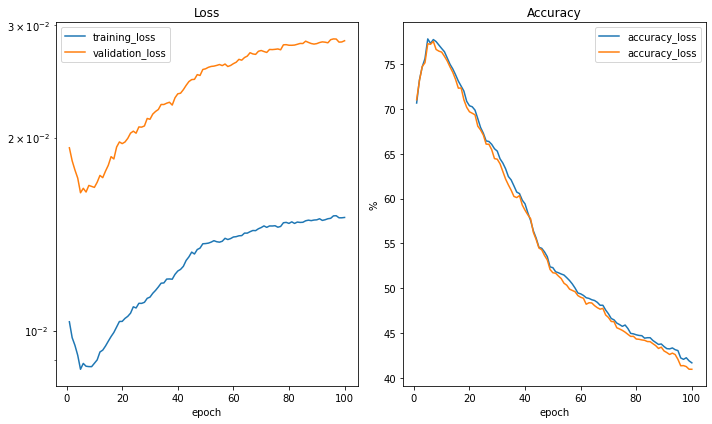


 for k=128


<ipython-input-7-55bef441b035>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.008774360268368742,Accuracy 0.7985673177003613

End of epoch  0, Validation error 0.016433384388158744, Validation accuracy 0.7992142857142858

End of epoch  1, Training error 0.008202370449603421,Accuracy 0.8190779403661299

End of epoch  1, Validation error 0.015350164527470322, Validation accuracy 0.8200714285714286

End of epoch  2, Training error 0.007726069441127595,Accuracy 0.8367925876038287

End of epoch  2, Validation error 0.014444651577095013, Validation accuracy 0.8355

End of epoch  3, Training error 0.007630625784844264,Accuracy 0.8420988183432315

End of epoch  3, Validation error 0.01433206765492356, Validation accuracy 0.8431428571428572

End of epoch  4, Training error 0.007422581101956472,Accuracy 0.8482826180126125

End of epoch  4, Validation error 0.013963874674257405, Validation accuracy 0.8465

End of epoch  5, Training error 0.007495674334607649,Accuracy 0.8490377354639891

End of epoch  5, Validation error 0.0141498900262546

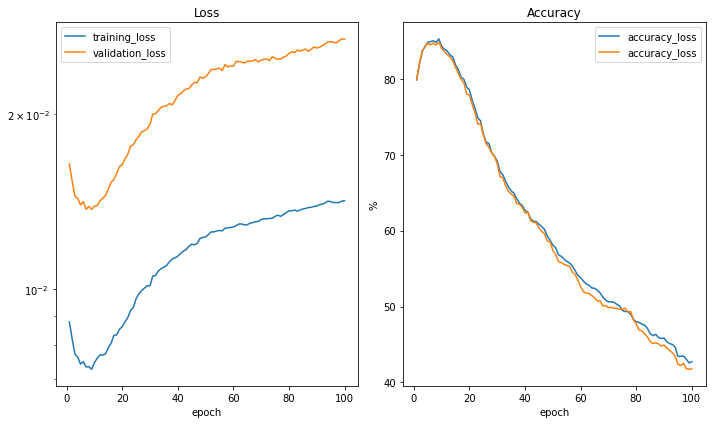


 for k=256


<ipython-input-7-55bef441b035>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.007025473877291003,Accuracy 0.8697320353476602

End of epoch  0, Validation error 0.01328168141556218, Validation accuracy 0.8673571428571428

End of epoch  1, Training error 0.0068317549300946434,Accuracy 0.8791199820404498

End of epoch  1, Validation error 0.012965220351984389, Validation accuracy 0.8765714285714286

End of epoch  2, Training error 0.006505280819893978,Accuracy 0.8871201453090879

End of epoch  2, Validation error 0.012302729081677075, Validation accuracy 0.8867142857142857

End of epoch  3, Training error 0.006264436747207656,Accuracy 0.8933855792975367

End of epoch  3, Validation error 0.012037992577922717, Validation accuracy 0.8919285714285714

End of epoch  4, Training error 0.0061510795830410575,Accuracy 0.8956305230718994

End of epoch  4, Validation error 0.011933275377049246, Validation accuracy 0.8934285714285715

End of epoch  5, Training error 0.006105713636904914,Accuracy 0.8982224127023001

End of epoch  5, Validatio

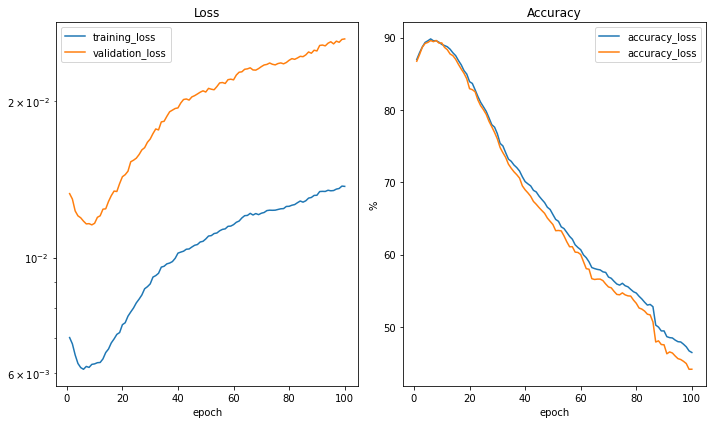


 for k=512


<ipython-input-7-55bef441b035>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.005896207880708326,Accuracy 0.907528725076022

End of epoch  0, Validation error 0.01117851437685122, Validation accuracy 0.9073571428571429

End of epoch  1, Training error 0.005593403102984803,Accuracy 0.9162840057960366

End of epoch  1, Validation error 0.010831030629159718, Validation accuracy 0.9133571428571429

End of epoch  2, Training error 0.0054785158885643954,Accuracy 0.9203249045898896

End of epoch  2, Validation error 0.010402364330933106, Validation accuracy 0.9193571428571429

End of epoch  3, Training error 0.005419352236471495,Accuracy 0.923284148656095

End of epoch  3, Validation error 0.01016396194645472, Validation accuracy 0.9228571428571428

End of epoch  4, Training error 0.005270789840668161,Accuracy 0.9258556297067287

End of epoch  4, Validation error 0.009988513811536997, Validation accuracy 0.9245

End of epoch  5, Training error 0.005192048585202409,Accuracy 0.9273658646094818

End of epoch  5, Validation error 0.009961

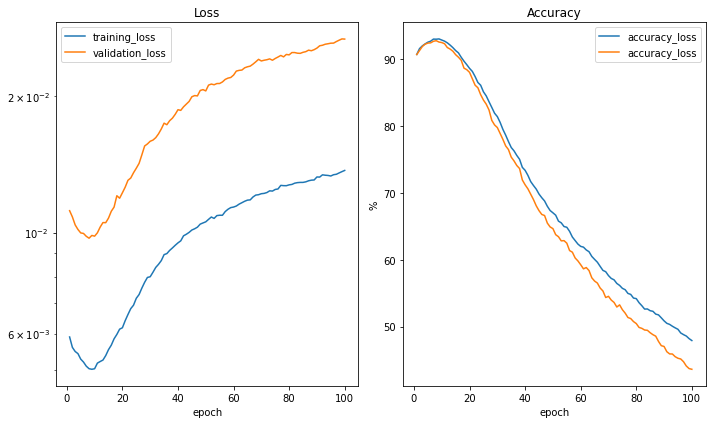


 for k=1024


<ipython-input-7-55bef441b035>:58: RuntimeWarning: overflow encountered in double_scalars
  if (np.linalg.norm(beta_temp[:,k], ord=2)



End of epoch  0, Training error 0.0050302491779636626,Accuracy 0.93257005245005

End of epoch  0, Validation error 0.009621669845315048, Validation accuracy 0.9297142857142857

End of epoch  1, Training error 0.004798664287311577,Accuracy 0.9391212065552358

End of epoch  1, Validation error 0.009037055236466068, Validation accuracy 0.9377857142857143

End of epoch  2, Training error 0.004517355112927641,Accuracy 0.9440396742790669

End of epoch  2, Validation error 0.008835226340609273, Validation accuracy 0.9387142857142857

End of epoch  3, Training error 0.004427015650274244,Accuracy 0.9470805526643401

End of epoch  3, Validation error 0.00855325454229594, Validation accuracy 0.9435714285714286

End of epoch  4, Training error 0.004282447600440289,Accuracy 0.9504479683258842

End of epoch  4, Validation error 0.00835347905036566, Validation accuracy 0.9454285714285714

End of epoch  5, Training error 0.004165800581811899,Accuracy 0.9519173860691035

End of epoch  5, Validation er

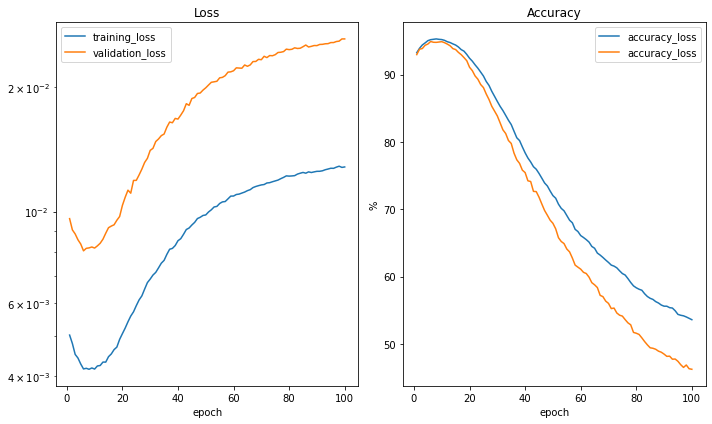

In [9]:
K = np.arange(0,11) 
K = 2**K

accuracy_valid_max_list = []

for k in K: 
    
    print("\n for k=" + str(k))
    
    seed = 1
    np.random.seed(seed)
    d = 784

    accuracy_valid_max = result_plot(x_train, y_train, x_valid, y_valid, x_test, y_test, 
                                     M = 100, K = k, lambda_ = 0.1, delta = 0.1, gamma = 3*d - 2)
    
    accuracy_valid_max_list = np.append(accuracy_valid_max_list, accuracy_valid_max)

[[   1.      14.1  ]
 [   2.      17.229]
 [   4.      28.971]
 [   8.      39.479]
 [  16.      53.593]
 [  32.      67.029]
 [  64.      77.521]
 [ 128.      84.857]
 [ 256.      89.6  ]
 [ 512.      92.807]
 [1024.      94.921]]


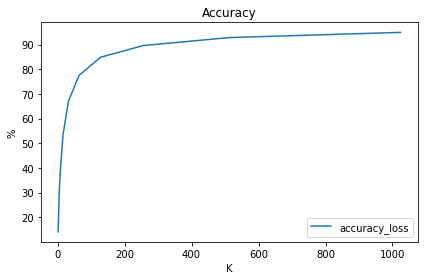

In [14]:
accuracy_table = np.append(K, accuracy_valid_max_list*100).reshape((11,2), order='F')
np.set_printoptions(precision=3, suppress=True)
print(accuracy_table)

plt.plot(K, accuracy_valid_max_list*100, label = 'accuracy_loss')
plt.legend()
plt.xlabel('K')
plt.ylabel('%')
plt.title('Accuracy')
plt.tight_layout()
plt.show()